In [1]:
%cd "~/Skorch/ProtienDT/Fang'sTask"

/home/myf/Skorch/ProtienDT/Fang'sTask


In [2]:
import torch #type:ignore
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:",device)

import numpy as np #type:ignore
from meta_net import *
import MoNet as mn
from sklearn.pipeline import Pipeline #type:ignore
from sklearn.preprocessing import StandardScaler #type:ignore
from sklearn.decomposition import PCA #type:ignore

def model_init(module,jobName,load_mode=0):
    # 回调函数#type:ignore
    from skorch.callbacks import Checkpoint, TrainEndCheckpoint , EarlyStopping #type:ignore
    from meta_net.load import LoadCopyState
    cp_val = Checkpoint(dirname="model/"+jobName,f_pickle="model.pt",monitor='valid_loss_best',fn_prefix='val_')#type:ignore
    cp_end = TrainEndCheckpoint(dirname="model/"+jobName,f_pickle="model.pt",fn_prefix='end_')
    init_state=[None,LoadInitState(cp_val),LoadCopyState(cp_val),LoadCopyState(cp_end),LoadInitState(cp_end)][load_mode]

    # 模型运行
    module.set_params(
        optimizer=torch.optim.NAdam,  # 优化器 #type:ignore
        max_epochs=100,  # 最大迭代次数
        batch_size=128,  # 批次大小
        callbacks=[EarlyStopping(monitor='valid_loss',patience=10,load_best=False), #type:ignore
                   init_state,cp_val,cp_end], 
        device=device,  # 使用cpu或者cuda #type:ignore
        warm_start=True,
        iterator_train__shuffle=True
    )

    model = Pipeline([('sc',StandardScaler()),('pca',PCA(n_components=256)),('nn',module)])
    print(model)
    return model

def run_model(model,X, y,Reg_mode=0):
    from sklearn.model_selection import train_test_split #type:ignore
    from torchsummary import summary
    summary((module:=model['nn']).module,input_data=[256],depth=128)
    
    train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.2, random_state=2023)
    train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1, random_state=2023)
    model.fit(train_X,train_y)
    
    print(train_score:="train_score: %.3f"%model.score(train_X,train_y)+f" num:{len(train_X)}")
    print(valid_score:="valid_score: %.3f"%model.score(valid_X,valid_y)+f" num:{len(valid_X)}")
    print(test_score :="test_score : %.3f"%model.score(test_X,test_y)+f" num:{len(test_X)}")
    
    import matplotlib.pyplot as plt
    import pandas as pd
    import sklearn.metrics as M
    fig,axs=plt.subplots(1,4,figsize=(20,4))
    
    pd.DataFrame(module.history[:,label:=('train_loss','dur','valid_loss')],columns=label).plot(ax=axs[0])
    axs[0].set_title(f"Best epoch:{len(best:=module.history[:,'valid_loss_best'])-best[::-1].index(True)}")
    if Reg_mode:
        pd.DataFrame([*(y_true:=train_y).T,*(y_pred:=model.predict(train_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[1])
        pd.DataFrame([*(y_true:=test_y).T,*(y_pred:=model.predict(test_X)).T],index=['True','Pred']).T.plot.scatter(x=0,y=1,c=y_pred-y_true,cmap='viridis',ax=axs[2])
        pd.DataFrame(PCA(2).fit_transform(X)).plot.scatter(x=0,y=1,c=(error:=model.predict(X)-y),cmap='viridis',ax=axs[3])
    else:
        print(M.classification_report(y,model.predict(X),zero_division=0))
        M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=train_y,y_pred=model.predict(train_X))).plot(ax=axs[1])
        M.ConfusionMatrixDisplay(M.confusion_matrix(y_true=test_y,y_pred=model.predict(test_X))).plot(ax=axs[2])
        pd.DataFrame(PCA(2).fit_transform(X)).plot.scatter(x=0,y=1,c=(error:=model.predict(X)-y),cmap='viridis',ax=axs[3])
        
    axs[1].set_title(train_score)
    axs[2].set_title(test_score)
    axs[3].set_title("mean_error: %.3f"%error.mean())
    
    fig.suptitle(jobName)
    torch.save(model,f"model/{jobName}.final.pt")

device: cuda
pytorch: 2.1.1+cu121 device: cuda


(10959, 7) Index(['Protein', 'Sequence', 'len',
       'Similarity plus ratio/Number of products', 'Number of products',
       'Final product similarity', 'Str_X'],
      dtype='object')


<Axes: ylabel='Frequency'>

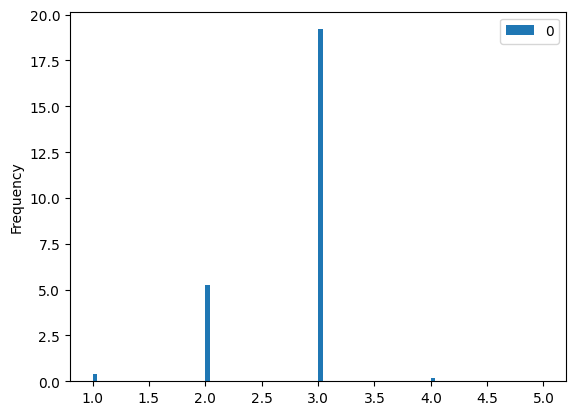

In [3]:
# 加载数据
import pandas as pd #type:ignore
import safetensors.torch as sft #type:ignore
plt.style.use('default')

data=pd.read_pickle("data/data.pkl")
print(data.shape, data.columns) #type:ignore
Y_list = (Y1,Y2,Y3)=data['Similarity plus ratio/Number of products'],data['Number of products'] ,data['Final product similarity'] #type:ignore
y = Y2.to_numpy().reshape(-1).astype(int)
pd.DataFrame(y).plot.hist(bins=100,density=True)

分类

In [ ]:
model="NormMLP_Reg_Y2"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = R(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[256,256,128,128],1],
    [["fc", "bn",'act.RReLU',"dp_0.5"], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.SmoothL1Loss,
    optimizer__lr=0.015,
    max_epochs=1000,
    callbacks__EarlyStopping__patience=100)

run_model(model,X,y.astype(np.float32),1)

<class 'numpy.dtypes.Float32DType'> (10959, 320) 
 <class 'numpy.dtypes.Float32DType'> (10959, 320) 
 <class 'numpy.dtypes.Int64DType'> (10959,)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.5, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=128, bias=T...
                  (3:dp): Dropout(p=0.2, inplace=False)
                )
              )
              (3): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=64, out_features=64, bias=True)
                  (1:bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/myf/Skorch/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.6054       0.8638        0.4459     +  0.2676
      2        0.4439       0.8866        0.4117     +  0.2635
      3        0.4292       0.8257        0.4118        0.2614
      4        0.4232       0.8790        0.3271     +  0.2643
      5        0.4059       0.8904        0.3140     +  0.2579
      6        0.4004       0.8923        0.2965     +  0.2738
      7        0.3924       0.8910        0.3386        0.2560
      8        0.3972       0.8859        0.3361        0.2645
      9        0.3945       0.8783        0.3320        0.2484
     10        0.3895       0.8897        0.3619        0.2613
     11        0.3803       0.8847        0.3186        0.2597
     12        0.3743       0.8828        0.3138        0.2653
     13        0.3787       0.8885        0.3227        0.2610
     14        0.3716       0.8878        0.3021       

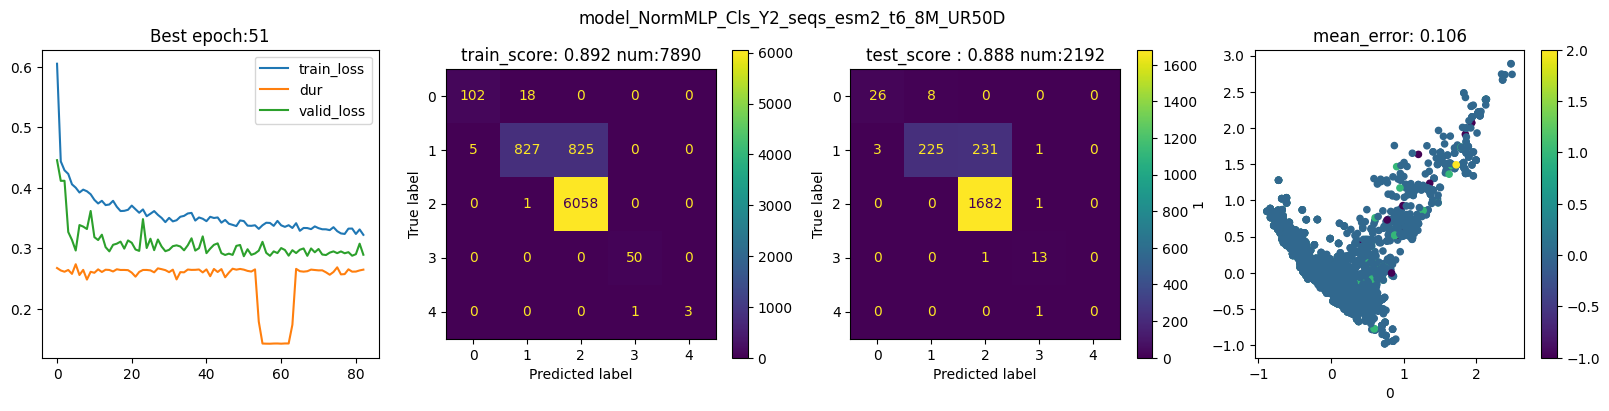

In [25]:
model="NormMLP_Cls_Y2"
Embedding="seqs_esm2_t6_8M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = C(mn.Layer(1,1,'dp_0.5')*mn.Mix(0,
    [[128,128,64,64],int(max(y)+1)],
    [["fc","bn",'act.RReLU','dp_0.2'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.CrossEntropyLoss,
    optimizer__lr=0.015,
    max_epochs=1000,
    callbacks__EarlyStopping__patience=32)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1280) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1280) 
 <class 'numpy.dtypes.Int64DType'> (10959,)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.5, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=128, bias=T...
                  (3:dp): Dropout(p=0.2, inplace=False)
                )
              )
              (3): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=64, out_features=64, bias=True)
                  (1:bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/myf/Skorch/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5696       0.8878        0.3018     +  0.2580
      2        0.4109       0.8897        0.2991     +  0.2433
      3        0.3871       0.8904        0.2901     +  0.2587
      4        0.3687       0.8929        0.3210        0.2716
      5        0.3745       0.8929        0.3110        0.2641
      6        0.3572       0.8910        0.2914        0.2601
      7        0.3497       0.8929        0.2860     +  0.2523
      8        0.3520       0.8923        0.2849     +  0.2594
      9        0.3468       0.8935        0.2799     +  0.2573
     10        0.3435       0.8923        0.2815        0.2595
     11        0.3357       0.8923        0.2790     +  0.2575
     12        0.3342       0.8935        0.2816        0.2544
     13        0.3375       0.8929        0.2785     +  0.2651
     14        0.3264       0.8929        0.2761     + 

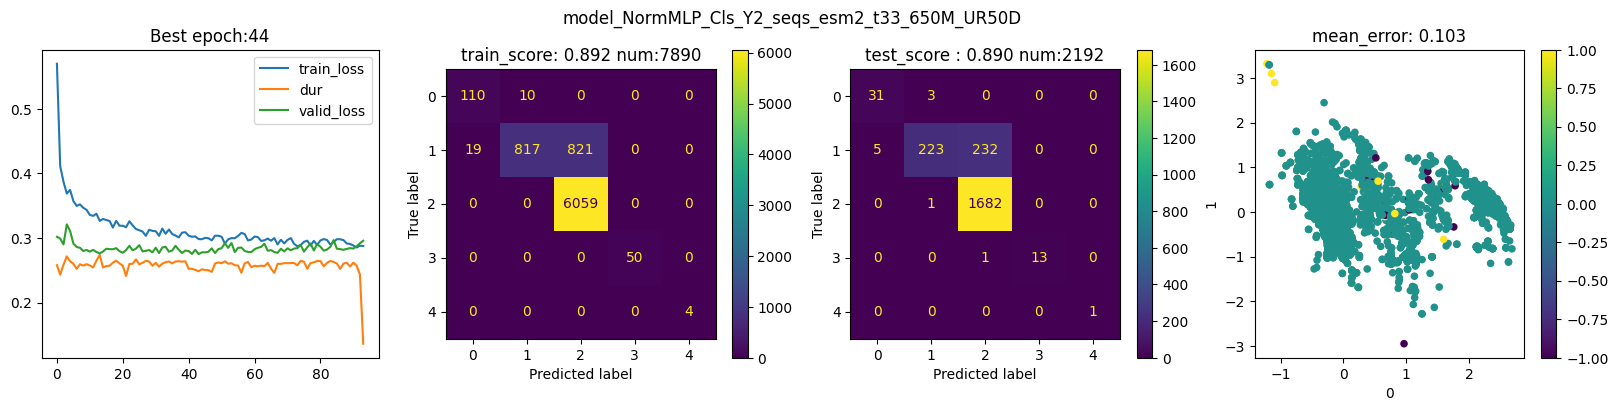

In [26]:
model="NormMLP_Cls_Y2"
Embedding="seqs_esm2_t33_650M_UR50D"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module = C(mn.Layer(1,1,'dp_0.5')*mn.Mix(0,
    [[128,128,64,64],int(max(y)+1)],
    [["fc","bn",'act.GELU','dp_0.2'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.CrossEntropyLoss,
    optimizer__lr=0.015,
    max_epochs=1000,
    callbacks__EarlyStopping__patience=50)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1282) 
 <class 'numpy.dtypes.Float32DType'> (10959, 1282) 
 <class 'numpy.dtypes.Int64DType'> (10959,)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.2, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=256, bias=T...
                  (2:act): ReLU()
                  (3:dp): Dropout(p=0.5, inplace=False)
                )
              )
              (1): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=256, out_features=128, bias=True)
                  (1:bn): BatchNorm1d(128, eps=1e-05, momentum

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/myf/Skorch/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5729       0.8454        0.4297     +  0.1610
      2        0.4537       0.8517        0.4046     +  0.1659
      3        0.4292       0.8542        0.3966     +  0.1441
      4        0.4061       0.8593        0.4025        0.1367
      5        0.3957       0.8701        0.3872     +  0.1518
      6        0.3886       0.8676        0.3853     +  0.1881
      7        0.3776       0.8669        0.3940        0.1458
      8        0.3773       0.8726        0.3792     +  0.1198
      9        0.3569       0.8714        0.3944        0.1425
     10        0.3611       0.8733        0.3930        0.1551
     11        0.3496       0.8720        0.4218        0.1674
     12        0.3503       0.8745        0.3917        0.1241
     13        0.3520       0.8758        0.3936        0.2070
     14        0.3416       0.8707        0.4058       

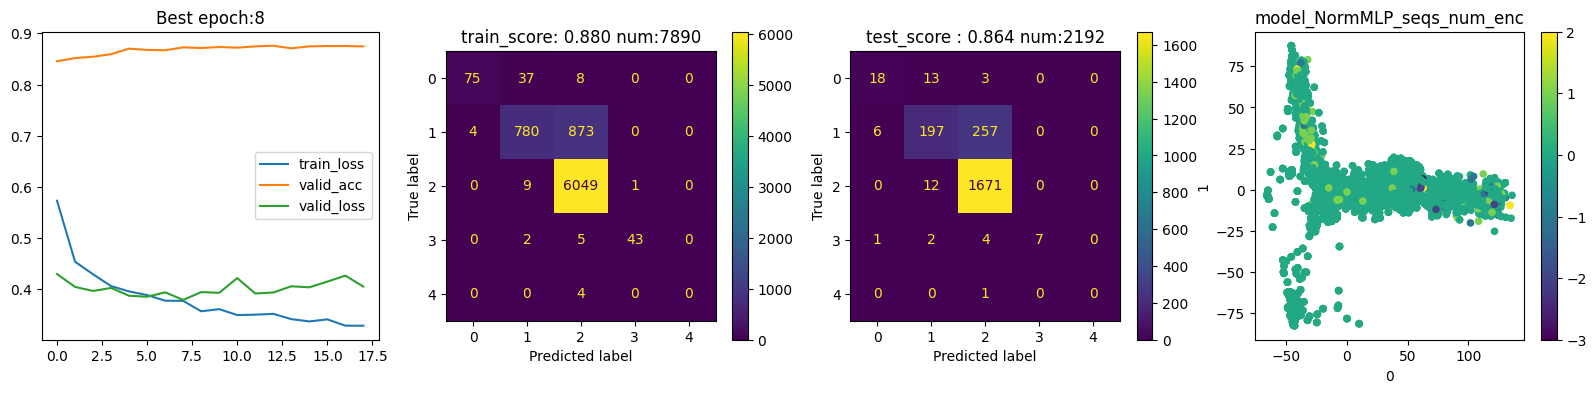

In [71]:
model="NormMLP"
Embedding="seqs_num_enc"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module =C(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[256,128],int(max(y)+1)],
    [["fc", 'bn', 'act.ReLU', 'dp_0.5'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.CrossEntropyLoss,
    optimizer__lr=0.015,
    max_epochs=100,
    callbacks__EarlyStopping__patience=10)

run_model(model,X,y)

<class 'numpy.dtypes.Float32DType'> (10959, 1280, 23) 
 <class 'numpy.dtypes.Float32DType'> (10959, 29440) 
 <class 'numpy.dtypes.Int64DType'> (10959,)
Pipeline(steps=[('sc', StandardScaler()), ('pca', PCA(n_components=256)),
                ('nn',
                 <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MoNet(
    (Net): Sequential(
      (0): Layer(
        (Net): Dropout(p=0.2, inplace=False)
      )
      (1): Mix(
        (Net): Sequential(
          (0:input): SeqCell(
            (Net): Sequential(
              (0): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=0, out_features=256, bias=T...
                  (2:act): ReLU()
                  (3:dp): Dropout(p=0.5, inplace=False)
                )
              )
              (1): Cell(
                (Net): Sequential(
                  (0:fc): Linear(in_features=256, out_features=128, bias=True)
                  (1:bn): BatchNorm1d(128, eps=1e-05, mom

/home/myf/Skorch/.venv/lib/python3.10/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/home/myf/Skorch/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5766       0.8422        0.4551     +  0.1377
      2        0.4538       0.8523        0.3816     +  0.1565
      3        0.4247       0.8523        0.3708     +  0.1245
      4        0.4075       0.8555        0.3747        0.1643
      5        0.3942       0.8568        0.3625     +  0.1520
      6        0.4045       0.8599        0.3682        0.1378
      7        0.3825       0.8580        0.3705        0.2140
      8        0.3707       0.8612        0.3659        0.2148
      9        0.3765       0.8593        0.3672        0.1420
     10        0.3601       0.8612        0.3684        0.1548
     11        0.3641       0.8619        0.3763        0.1668
     12        0.3652       0.8644        0.3731        0.1567
     13        0.3610       0.8638        0.3789        0.2088
     14        0.3526       0.8644        0.3743       

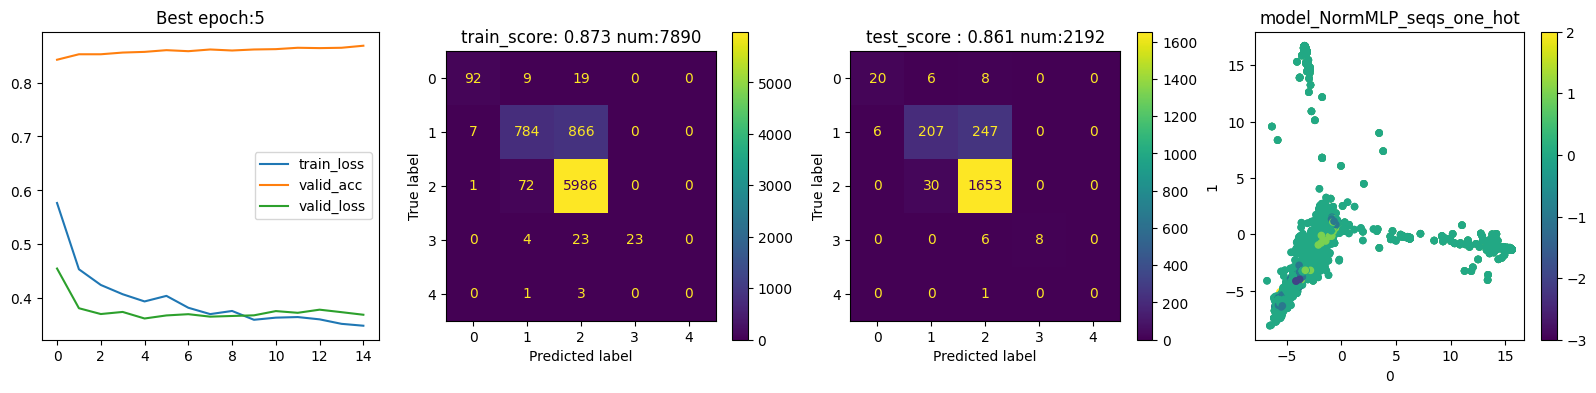

In [72]:
model="NormMLP"
Embedding="seqs_one_hot"
jobName=f"model_{model}_{Embedding}"

# 加载数据
Xdata = sft.load_file(f"data/{Embedding}.sft")['encs'].numpy().astype(np.float32)
X = Xdata.reshape(len(Xdata),-1)
print(type(Xdata.dtype),Xdata.shape,'\n',type(X.dtype),X.shape,'\n',type(y.dtype),y.shape)

module =C(mn.Layer(1,1,'dp_0.2')*mn.Mix(0,
    [[256,128],int(max(y)+1)],
    [["fc", 'bn', 'act.ReLU', 'dp_0.5'], "fc"]))
model=model_init(module,jobName,0)
module.set_params(
    criterion=torch.nn.CrossEntropyLoss,
    optimizer__lr=0.015,
    max_epochs=100,
    callbacks__EarlyStopping__patience=10)

run_model(model,X,y)